# Vulnerability analysis

This notebook contains analysis of vulnerabilities in Common Criteria certificates. 

## Executive summary

- Weak correlations (in a sensible direction, i.e., negative correlations) between expert-selected SARs that could correspond to more secure products and number/severity of vulnerabilities. Same correlations exist on more coarser scale of EALs
- Maintenannce updates very rarely used to address vulnerabilities. Instead, they often make claims about vulnerabilities not being applicable to the *certified version* of the product. The rationale is often mentioned in the non-public Impact Analysis Report
- Approximately 50% of vulns. exist prior to certification, these are seldomly referenced in the certificatation documents (TODO: double-check). 
- In combination with dependency map between certificates, the ecosystem is quite fragile, as a single vulnerability on average affects X certs directly and Y certs indirectly
- Some categories heavily underrepresented in the CPE/CVE landscape, e.g., smartcards

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional
from tqdm.notebook import tqdm

from typing import Set
from sec_certs.sample.sar import SAR
plt.style.use("ggplot")

from sec_certs.dataset import CCDataset, CVEDataset, CCDatasetMaintenanceUpdates
from sec_certs.sample import CommonCriteriaCert
import datetime

import itertools

from sec_certs.pandas_helpers import compute_cve_correlations, find_earliest_maintenance_after_cve, expand_cc_df_with_cve_cols, compute_maintenances_that_should_fix_vulns, move_fixing_mu_to_directory

## Retrieve necessary objects from sec-certs

In [2]:
# Download and save fresh snapshot
# dset: CCDataset = CCDataset.from_web_latest()
# dset.to_json("/Users/adam/phd/projects/certificates/datasets/from_web_latest/latest.json")

# Local instantiation
dset: CCDataset = CCDataset.from_json('/Users/adam/phd/projects/certificates/sec-certs/datasets/from_web_latest/dataset.json')
main_dset = dset.mu_dataset
cve_dset: CVEDataset = dset._prepare_cve_dataset()

# Fully remote instantiation
# dset: CCDataset = CCDataset.from_web_latest()
# main_dset: CDatasetMaintenanceUpdates = CCDatasetMaintenanceUpdates.from_web_latest()
# cve_dset: CVEDataset = CVEDataset.from_web()

parsing cpe matching (by NIST) dictionary: 100%|██████████| 377628/377628 [00:34<00:00, 10810.92it/s]
Building-up lookup dictionaries for fast CVE matching: 100%|██████████| 183838/183838 [00:14<00:00, 12615.84it/s]


### Dataset preprocessing

- Loads `CCDataset` into pandas DataFrame
- Expands it with various maintenance-related columns
- Expands it with various CVE-related columns

In [3]:
df = dset.to_pandas()

if 'n_maintenances' not in df.columns:
    n_maintenances = main_dset.get_n_maintenances_df()
    df = pd.concat([df, n_maintenances], axis='columns')

if 'maintenance_dates' not in df.columns:
    main_dates = main_dset.get_maintenance_dates_df()
    df = pd.concat([df, main_dates], axis='columns')

# Limit CVE DataFrame to relevant CVEs
cves = list(itertools.chain.from_iterable([x.heuristics.related_cves for x in dset if x.heuristics.related_cves]))
cve_dict = {x: cve_dset[x] for x in cves}
cve_dset.cves = cve_dict

df = expand_cc_df_with_cve_cols(df, cve_dset)

In [4]:
# Take a look at columns related to CVEs
df.loc[~df.related_cves.isna(), ['related_cves', 'cve_published_dates', 'earliest_cve', 'worst_cve']]

,related_cves,cve_published_dates,earliest_cve,worst_cve
c4bd865f2ae51533,{CVE-2019-5408},[2019-08-09],2019-08-09,6.5
ebd276cca70fd723,"{CVE-2019-4513, CVE-2017-1732}","[2019-08-26, 2018-08-17]",2018-08-17,8.2
7a53ce3f91bf73c7,"{CVE-2017-14800, CVE-2017-9276, CVE-2017-14799...","[2018-03-01, 2018-03-02, 2018-03-01, 2018-03-0...",2018-03-01,6.1
b2aea954a265af60,"{CVE-2021-44168, CVE-2021-42757, CVE-2021-2610...","[2022-01-04, 2021-12-08, 2021-12-08, 2021-08-0...",2020-09-24,9.8
28819ed8f96586bc,"{CVE-2021-44168, CVE-2021-42757, CVE-2021-2610...","[2022-01-04, 2021-12-08, 2021-12-08, 2021-08-0...",2020-09-24,9.8
...,...,...,...,...
5f1df5ad8e51ba75,"{CVE-2007-0411, CVE-2005-4704, CVE-2006-0427, ...","[2007-01-23, 2005-12-31, 2006-01-25, 2007-01-2...",2003-08-27,10.0
ffeef32299d913d6,"{CVE-2008-1592, CVE-2009-0439, CVE-2008-1130}","[2008-03-31, 2009-02-24, 2008-03-04]",2008-03-04,7.2
a092aebf5a286ded,{CVE-2004-2558},[2004-12-31],2004-12-31,7.5
ace069b9b7c10f19,{CVE-2000-0772},[2000-10-20],2000-10-20,7.5


## Plot distribution of categories in CPE-rich vs. all certificates

<AxesSubplot:title={'center':'Categories (without smartcards) comparison between CPE-rich, CVE-rich and all certificates'}>

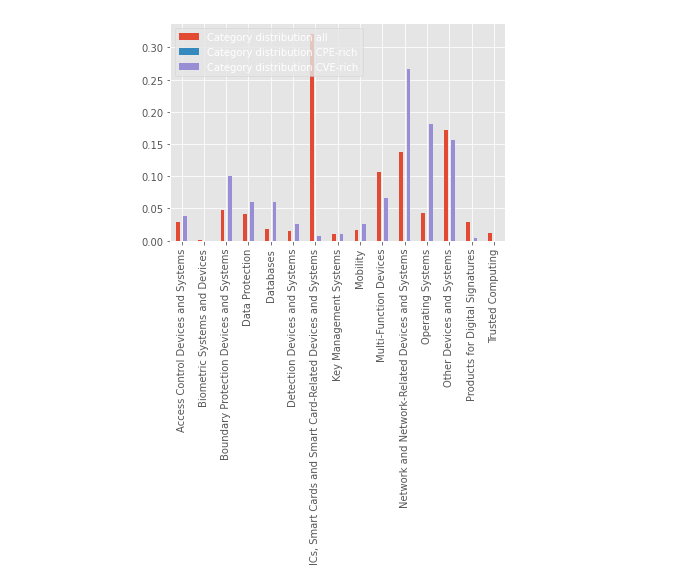

In [6]:
df_cpe_rich = df.loc[~df.verified_cpe_matches.isnull()].copy()
df_cve_rich = df.loc[df.n_cves > 0].copy()

categories_cpe = df_cpe_rich.category.value_counts().sort_index().rename('Category distribution CPE-rich')
categories_cve = df_cve_rich.category.value_counts().sort_index().rename('Category distribution CVE-rich')
categories_all = df.category.value_counts().sort_index().rename('Category distribution all')

categories_merged = pd.concat([categories_all, categories_cpe, categories_cve], axis=1)
categories_merged = categories_merged.div(categories_merged.sum(axis=0), axis=1)
categories_merged.plot.bar(title='Categories (without smartcards) comparison between CPE-rich, CVE-rich and all certificates')

## Plot distribution of years in CPE-rich, CVE-rich, and all certificates

<AxesSubplot:title={'center':'Years comparision between CPE-rich, CVE-rich and all certificates'}>

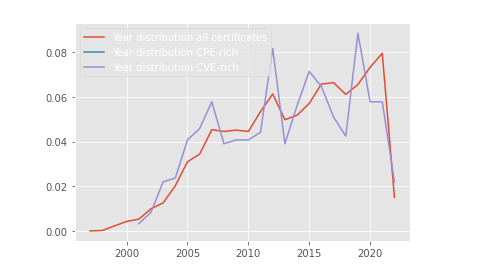

In [7]:
years_cpe = df_cpe_rich.year_from.value_counts().sort_index().rename('Year distribution CPE-rich')
years_cve = df_cve_rich.year_from.value_counts().sort_index().rename('Year distribution CVE-rich')
years_all = df.year_from.value_counts().sort_index().rename('Year distribution all certificates')

years_merged = pd.concat([years_all, years_cpe, years_cve], axis=1)
years_merged = years_merged.div(years_merged.sum(axis=0), axis=1)
years_merged.plot.line(title='Years comparision between CPE-rich, CVE-rich and all certificates')

## Plot distribution of security levels in CPE-rich, CVE-rich and all certificates

<AxesSubplot:title={'center':'Highest security level comparision between CPE-rich, CVE-rich and all certificates'}>

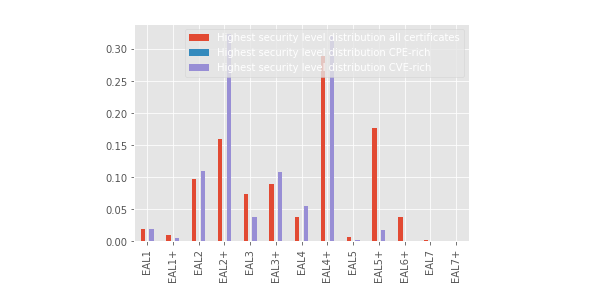

In [8]:
levels_cpe = df_cpe_rich.highest_security_level.value_counts().sort_index().rename('Highest security level distribution CPE-rich')
levels_cve = df_cve_rich.highest_security_level.value_counts().sort_index().rename('Highest security level distribution CVE-rich')
levels_all = df.highest_security_level.value_counts().sort_index().rename('Highest security level distribution all certificates')

levels_merged = pd.concat([levels_all, levels_cpe, levels_cve], axis=1)
levels_merged = levels_merged.div(levels_merged.sum(axis=0), axis=1)
levels_merged.plot.bar(title='Highest security level comparision between CPE-rich, CVE-rich and all certificates')

## Plot distribution of most common (top 20) vendors in CPE-rich, CVE-rich and all certificates

<AxesSubplot:title={'center':'Common vendors comparison between CPE-rich, CVE-rich and all certificates'}>

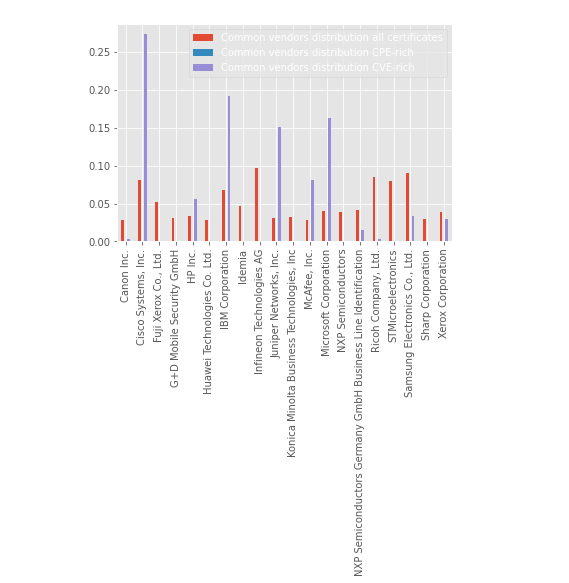

In [9]:
top_manufacturers = list(df.manufacturer.value_counts().head(20).index)
vendors_cpe = df_cpe_rich.loc[df_cpe_rich.manufacturer.isin(top_manufacturers), 'manufacturer'].value_counts().sort_index().rename('Common vendors distribution CPE-rich')
vendors_cve = df_cve_rich.loc[df_cve_rich.manufacturer.isin(top_manufacturers), 'manufacturer'].value_counts().sort_index().rename('Common vendors distribution CVE-rich')
vendors_all = df.loc[df.manufacturer.isin(top_manufacturers), 'manufacturer'].value_counts().sort_index().rename('Common vendors distribution all certificates')

vendors_merged = pd.concat([vendors_all, vendors_cpe, vendors_cve], axis=1)
vendors_merged = vendors_merged.div(vendors_merged.sum(axis=0), axis=1)
vendors_merged.plot.bar(title='Common vendors comparison between CPE-rich, CVE-rich and all certificates')

## Correlations between (EAL, SAR) and CVEs

In [10]:
df_corr_all = compute_cve_correlations(df, exclude_vuln_free_certs = False, output_path="/Users/adam/phd/projects/certificates/sec-certs/data/sar_correlations/all_certs_sar_cve_corr.csv")
df_corr_vuln_rich = compute_cve_correlations(df, exclude_vuln_free_certs = True, output_path="/Users/adam/phd/projects/certificates/sec-certs/data/sar_correlations/vuln_rich_certs_sar_cve_corr.csv")

  0%|          | 0/135 [00:00<?, ?it/s]

/Users/adam/phd/projects/certificates/sec-certs/certsvenv/lib/python3.8/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/adam/phd/projects/certificates/sec-certs/certsvenv/lib/python3.8/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


  0%|          | 0/135 [00:00<?, ?it/s]

In [11]:
# Shows head of correlations of all certificates
df_corr_all.head()

,n_cves_corr,worst_cve_corr,support
EAL,-0.090801,-0.122635,4965
ADV_IMP,-0.067373,-0.011090,2075
ALC_TAT,-0.095240,-0.282163,1903
ALC_DVS,-0.064516,-0.320521,2803
ACM_SCP,-0.043073,0.058181,773


In [12]:
# Shows head of correlations of vuln-rich certificates
df_corr_vuln_rich.head()

,n_cves_corr,worst_cve_corr,support
EAL,-0.126538,-0.122635,589
ADV_IMP,-0.023401,-0.011090,151
ALC_TAT,-0.110212,-0.282163,147
ALC_DVS,-0.033864,-0.320521,205
ACM_SCP,-0.098861,0.058181,103


## Time from CVE to maintenance update

The following block computes time from CVE to maintenance update of a certificate. Though, it has some limitations:
- So far we only watch for first CVE related to a certified product (though most of certificates have only one maintenance anyway, if they even have one)
- We assume that a maintance update released *after* (by date comparison) CVE fixes that vulnerability
- The sample size is small. Only 36 certificates have at least one CVE and at least one Maintenance update. Out of those, only 23 certificates have maintenance update that comes after a CVE
- Some stats is shown below, the quantiles in the number of days that it takes to fix the CVE are (267, 382, 562)
- Many certificates have some CVE (167) that is not fixed in a form of a maintenance update

In [6]:
n_unfixed_certs = df.loc[(df.n_cves>0) & (df.n_maintenances==0)].shape[0]
n_fixed_certs = df.loc[(df.n_cves>0) & (df.n_maintenances>0)].shape[0]
print(f'Number of certificates with >0 CVEs but 0 maintenance reports: {n_unfixed_certs}')
print(f'Number of certificates with >0 CVEs and >0 maintenance reports: {n_fixed_certs}')

df_fixed = compute_maintenances_that_should_fix_vulns(df)
print(df_fixed.loc[~df_fixed.time_to_fix_cve.isnull()]['time_to_fix_cve'].describe())
mu_filenames = move_fixing_mu_to_directory(df_fixed, main_dset.to_pandas(), "/Users/adam/Downloads/mu", "/Users/adam/phd/projects/certificates/sec-certs/datasets/from_web_latest/certs/maintenances/reports/pdf")

Number of certificates with >0 CVEs but 0 maintenance reports: 0
Number of certificates with >0 CVEs and >0 maintenance reports: 27
count                             23
mean     857 days 22:57:23.478260864
std      860 days 23:37:09.219855856
min                 34 days 00:00:00
25%                272 days 00:00:00
50%                541 days 00:00:00
75%                962 days 12:00:00
max               3752 days 00:00:00
Name: time_to_fix_cve, dtype: object
